In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from tensorflow_probability import distributions as tfd

from datetime import datetime

from utils import *

In [3]:
mnist = tf.keras.datasets.mnist


In [4]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [228]:
tf.reset_default_graph()


In [229]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [230]:
n_z = 2
n_class = 10
batchsize = 64

X = tf.placeholder(tf.float32, shape=[None, 784])
X_reshape = tf.reshape(X, [-1, 28,28,1])
label = tf.placeholder(tf.int32, shape=[None])
label_oh = tf.one_hot(label, 10)

# ENCODER
def encoder(x):
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
        h1 = lrelu(conv2d(x, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
        h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
        h2_flat = tf.reshape(h2,[-1, 7*7*32])
        
        class_ = tf.nn.softmax(dense(h2_flat, 7*7*32, n_class, "w_class"))
        class_ = tfd.Categorical(probs=class_)
        
        w_mean = dense(h2_flat, 7*7*32, n_z, "w_mean")
        w_stddev = tf.nn.softplus(dense(h2_flat, 7*7*32, n_z, "w_stddev"))
        posterior = tfd.MultivariateNormalDiag(w_mean, w_stddev)
        
        d_logit = tf.layers.dense(h2_flat, 1)
        d_prob = tf.nn.sigmoid(d_logit)
        discriminator = tfd.Bernoulli(probs=d_prob + 1e-8)
        
    return posterior, class_, discriminator

# DECODER
def decoder(z, class_):
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        z = tf.concat([z, class_], axis=1)
#         z = tf.layers.dense(z, n_z, activation = tf.nn.relu)
        z_develop = tf.layers.dense(z, 7*7*32, activation = tf.nn.relu)
        z_matrix = tf.nn.relu(tf.reshape(z_develop, [-1, 7, 7, 32]))
        h1 = tf.nn.relu(conv_transpose(z_matrix, [batchsize, 14, 14, 16], "g_h1"))
        h2 = conv_transpose(h1, [batchsize, 28, 28, 1], "g_h2")
        h2 = tf.nn.sigmoid(h2)
        h2 = tf.reshape(h2, [-1, 784])
        dec = tfd.Bernoulli(probs=h2 + 1e-8)
        dec = tfd.Independent(
            distribution=dec,
            reinterpreted_batch_ndims=1,
            )
    return dec, h2

# def discriminator(x):
#     with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
#         h1 = lrelu(conv2d(x, 1, 16, "d_h1")) # 28x28x1 -> 14x14x16
#         h2 = lrelu(conv2d(h1, 16, 32, "d_h2")) # 14x14x16 -> 7x7x32
#         h2_flat = tf.reshape(h2,[-1, 7*7*32])
        
# #         class_ = tf.nn.softmax(dense(h2_flat, 7*7*32, n_class, "w_class"))
# #         class_ = tfd.Categorical(probs=class_)
        
#         d_logit = tf.layers.dense(h2_flat, 1)
#         d_prob = tf.nn.sigmoid(d_logit)
#         discriminator = tfd.Bernoulli(probs=d_prob + 1e-8)
        
#     return discriminator #, class_

prior = tfd.MultivariateNormalDiag(tf.zeros(n_z), tf.ones(n_z))

# ENCODER
posterior, class_, discr_real = encoder(X_reshape)
class_sampled = tf.one_hot(class_.sample(), 10)
code = posterior.sample()
struct_loss = tf.reduce_sum((-1)*label_oh*tf.log(class_.probs+1e-8), axis=1)

# DECODER
dec, generated_flat = decoder(code, class_sampled)
sampled_flat = dec.sample()
generated_images = tf.reshape(generated_flat, [-1, 28,28,1])
sampled_images = tf.reshape(sampled_flat, [-1, 28,28,1])

# DISCRIMINATOR
_, gen_class_, discr_gen = encoder(generated_images)

# DISCRIMINATOR OPT
# discr_loss = -tf.reduce_mean(tf.log(discr_real.probs) + tf.log(1. - discr_gen.probs), axis=-1)
discr_loss = -tf.reduce_mean(discr_real.log_prob(tf.ones_like(discr_real.probs)) + discr_gen.log_prob(tf.zeros_like(discr_gen.probs)), axis=-1)
adv_likelihood = discr_gen.log_prob(tf.ones_like(discr_gen.probs))
# tf.reduce_mean(tf.log(discr_gen.probs), axis=-1 )


# LOSS
# latent_likelihood = prior.log_prob(code)
lambda_ = 20
alpha_ = 1
divergence = compute_mmd(code, prior.sample(200)) * (lambda_+alpha_-1)
div2 = tfd.kl_divergence(posterior, prior) * (1-alpha_)
likelihood = dec.log_prob(X)
elbo = likelihood - divergence - div2
cost = tf.reduce_mean(-elbo + struct_loss)

# likelihood = dec.log_prob(X) #dec.log_prob(X)/784
# divergence = tfd.kl_divergence(posterior, prior) * n_z
# elbo = likelihood - divergence #tf.reduce_mean(likelihood - divergence)
# cost = tf.reduce_mean(-elbo + struct_loss)

# TRAIN
varlist_e = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'encoder')
varlist_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'decoder')
varlist_ed = varlist_e+varlist_d
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost, var_list=varlist_ed)
D_optimizer = tf.train.AdamOptimizer(0.0001).minimize(discr_loss, var_list=varlist_d)
E_optimizer = tf.train.AdamOptimizer(0.0001).minimize(-adv_likelihood, var_list=varlist_e)


In [231]:
# MANIPULATE
class_choice = tf.placeholder(tf.int32, shape=[None])
class_choice_oh = tf.one_hot(class_choice, 10)
_, generated_flat_choice = decoder(code, class_choice_oh)
generated_images_choice = tf.reshape(generated_flat_choice, [-1, 28,28,1])

In [232]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [233]:
# ITERATOR
all_nums = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(lambda x,y: (tf.reshape(x,[784])/255,y))
it = all_nums.batch(batchsize).repeat().make_initializable_iterator()
nb = it.get_next()
sess.run(it.initializer)

single_num_ds = {}
sn_iterators = {}
next_batch = {}
for i in range(10):
    print(i)
    single_num_ds[i] = all_nums.filter(lambda x,y: tf.equal(y,i)).batch(batchsize).repeat()
    sn_iterators[i] = single_num_ds[i].make_initializable_iterator()
    next_batch[i] = sn_iterators[i].get_next()
    sess.run(sn_iterators[i].initializer)

next_batch[10] = nb

0
1
2
3
4
5
6
7
8
9


In [234]:
mb_size = batchsize
for it in range(1000):
    for i in range(11):
        X_mb, Y_mb = sess.run(next_batch[i])
#         X_mb, Y_mb = sess.run(nb)
        if len(X_mb)!=batchsize:
            continue
        
        run_tensors = (optimizer, D_optimizer, E_optimizer, cost, likelihood, divergence, struct_loss, discr_loss, adv_likelihood)
        
        _,_,_, c, l, d, s, dl,al = sess.run(run_tensors, 
                                         feed_dict={X: X_mb, label: Y_mb})
#             _, dl = sess.run((D_optimizer, discr_loss), 
#                                              feed_dict={X: X_mb, label: Y_mb})
#         _, al = sess.run((E_optimizer, adv_likelihood), 
#                                          feed_dict={X: X_mb, label: Y_mb})
    
    now = datetime.now()
    if it % 10 == 0:
        print('Iter: {}'.format(it))
        print('discriminator loss: {:.4}'. format(np.mean(dl)))
        print('cost: {:.4}'. format(np.mean(c)))
        print('likelihood: {:.4}'. format(np.mean(l)))
        print('adv likelihood: {:.4}'. format(np.mean(al)))
        print('divergence: {:.4}'. format(np.mean(d)))
        print('struct loss: {:.4}'. format(np.mean(s)))
        print(str(datetime.now()))
        print()
        


Iter: 0
discriminator loss: 1.432
cost: 532.9
likelihood: -530.4
adv likelihood: -0.6335
divergence: 0.1865
struct loss: 2.29
2019-05-20 09:23:25.886912

Iter: 10
discriminator loss: 2.881
cost: 217.8
likelihood: -211.8
adv likelihood: -0.06149
divergence: 3.954
struct loss: 2.037
2019-05-20 09:23:37.140276

Iter: 20
discriminator loss: 5.026
cost: 206.4
likelihood: -204.3
adv likelihood: -0.007303
divergence: 0.6678
struct loss: 1.419
2019-05-20 09:23:51.516909

Iter: 30
discriminator loss: 5.08
cost: 187.8
likelihood: -186.5
adv likelihood: -0.007335
divergence: 0.279
struct loss: 1.076
2019-05-20 09:24:04.594454

Iter: 40
discriminator loss: 5.785
cost: 174.4
likelihood: -173.0
adv likelihood: -0.004526
divergence: 0.5437
struct loss: 0.8358
2019-05-20 09:24:16.784202

Iter: 50
discriminator loss: 4.916
cost: 160.2
likelihood: -158.7
adv likelihood: -0.009306
divergence: 0.6453
struct loss: 0.8746
2019-05-20 09:24:29.065974

Iter: 60
discriminator loss: 5.138
cost: 163.8
likelihood:

Iter: 520
discriminator loss: 8.739
cost: 143.2
likelihood: -142.4
adv likelihood: -0.0001806
divergence: 0.5111
struct loss: 0.2562
2019-05-20 09:37:05.961633

Iter: 530
discriminator loss: 8.288
cost: 130.5
likelihood: -129.7
adv likelihood: -0.0002864
divergence: 0.6857
struct loss: 0.1446
2019-05-20 09:37:17.537876

Iter: 540
discriminator loss: 8.83
cost: 129.4
likelihood: -128.8
adv likelihood: -0.0001719
divergence: 0.3565
struct loss: 0.1886
2019-05-20 09:37:29.791756

Iter: 550
discriminator loss: 7.995
cost: 139.9
likelihood: -138.8
adv likelihood: -0.0004107
divergence: 0.7085
struct loss: 0.3651
2019-05-20 09:37:42.187740

Iter: 560
discriminator loss: 9.248
cost: 138.9
likelihood: -137.2
adv likelihood: -0.0001162
divergence: 1.529
struct loss: 0.1797
2019-05-20 09:37:54.717725

Iter: 570
discriminator loss: 8.975
cost: 134.9
likelihood: -134.4
adv likelihood: -0.0001507
divergence: 0.3354
struct loss: 0.2274
2019-05-20 09:38:08.938869

Iter: 580
discriminator loss: 8.985


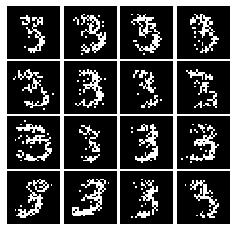

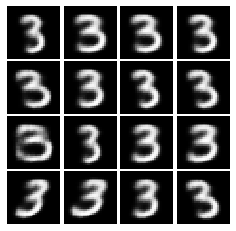

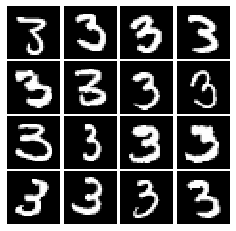

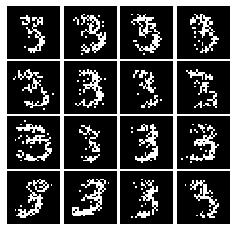

In [240]:
X_mb, _ = sess.run(next_batch[3])
g, s, r, z = sess.run([generated_images, sampled_images, X_reshape, code], feed_dict={X: X_mb})
plot(g)
plot(r)
plot(s)

In [236]:
sess.run(class_sampled, feed_dict = {X:X_mb})

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [39]:
dec

<tfp.distributions.Independent 'Independentdecoder/Bernoulli/' batch_shape=(64,) event_shape=(784,) dtype=int32>

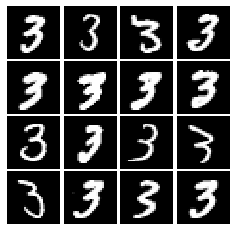

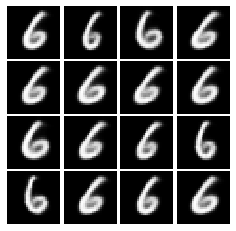

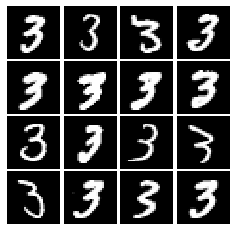

In [238]:
plot(sess.run(generated_images_choice, feed_dict = {X:X_mb, class_choice:[6 for i in range(batchsize)]}))
plot(X_mb)

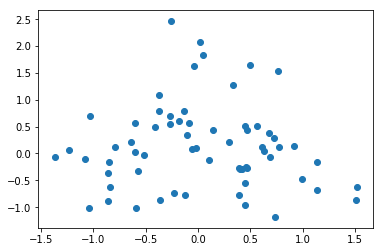

In [195]:
X_mb, _ = sess.run(next_batch[6])

code_ = sess.run(code, feed_dict = {X:X_mb})
plt.scatter(code_[:,0], code_[:,1])

In [105]:
code_

array([[ 1.4678175e+00, -1.3356371e+00],
       [ 9.2743272e-01, -1.8515942e-01],
       [ 4.3582931e-01, -6.3155645e-01],
       [-1.5983893e-01, -3.4920076e-01],
       [-2.7766457e-01, -1.3351055e+00],
       [-1.4641051e+00,  1.6781282e-01],
       [-9.0927672e-01,  2.2616987e+00],
       [-7.3767924e-01, -4.7797093e-01],
       [-3.2767286e+00,  1.3431939e+00],
       [ 1.9702911e-03, -6.2548369e-02],
       [ 7.7598071e-01,  1.2664051e+00],
       [ 2.0231943e+00,  9.6046686e-02],
       [-1.9918950e+00,  7.7832913e-01],
       [-1.3567327e+00, -1.8759108e+00],
       [ 1.3314703e+00, -1.4664866e-01],
       [ 9.3298262e-01, -1.3661673e+00],
       [-2.5838065e+00, -1.2016788e+00],
       [ 2.8566067e+00, -4.8160523e-01],
       [ 1.6553718e+00, -4.2547452e-01],
       [ 5.2662653e-01, -7.3520947e-01],
       [ 3.8343489e-01,  5.1898509e-01],
       [-1.3049355e+00,  4.8010936e-01],
       [ 2.2011509e+00,  1.4067138e+00],
       [ 5.5410683e-01, -6.4753205e-01],
       [-2.85235